# MLP training on MNIST

In [10]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
seed = 0
mnist_image_size = (28, 28)

def init_mlp(layer_width, parent_key, scale=0.01):
    params = []
    keys = jax.random.split(parent_key, num=len(layer_width) - 1)

    for in_width, out_width, key in zip(layer_width[:-1], layer_width[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
            scale * jax.random.normal(weight_key, shape=(out_width, in_width)),
            scale * jax.random.normal(bias_key, shape=(out_width,)),
        ])

    return params

key = jax.random.PRNGKey(seed)
mlp_params = init_mlp([784, 512, 256, 10], key)
print(jax.tree.map(lambda x: x.shape, mlp_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [4]:
def mlp_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)  # stable calc


# test single pass
dummy_image = np.random.randn(np.prod(mnist_image_size))
print(dummy_image.shape)

prediction = mlp_predict(mlp_params, dummy_image)
print(prediction.shape)

# test batched function
batched_mlp_predict = jax.vmap(mlp_predict, in_axes=(None, 0))

dummy_image_batched = np.random.randn(16, np.prod(mnist_image_size))
print(dummy_image_batched.shape)
predictions_batched = batched_mlp_predict(mlp_params, dummy_image_batched)
print(predictions_batched.shape)

(784,)
(512, 784) (784,)
(256, 512) (512,)
(10,)
(16, 784)
(512, 784) (784,)
(256, 512) (512,)
(16, 10)


In [6]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    images = np.array(transposed_data[0])

    return images, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=True, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
images = batch_data[0]
labels = batch_data[1]
print(images.shape, images[0].dtype, labels.shape, labels[0].dtype)

# optimization - laoding the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_labels = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_labels = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [9]:
num_epochs = 5

def loss_fn(params, images, labels):
    predictions = batched_mlp_predict(params, images)
    return -jnp.mean(predictions * labels)

def accuracy(params, dataset_images, dataset_labels):
    predictions = jnp.argmax(batched_mlp_predict(params, images), axis=1)
    return jnp.mean(predictions == dataset_labels)

@jax.jit
def update(params, images, labels, lr=0.01):
    loss, grad = jax.value_and_grad(loss_fn)(params, images, labels)
    return loss, jax.tree.map(lambda p, g: p - lr * g, params, grad)

mlp_params = init_mlp([np.prod(mnist_image_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        gt = jax.nn.one_hot(labels, len(MNIST.classes))

        loss, mlp_params = update(mlp_params, images, gt)
        if idx % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(mlp_params, train_images, labels)} test acc = {accuracy(mlp_params, test_images, labels)}')


(512, 784) (784,)
(256, 512) (512,)
0.25124627
0.08253209
0.058283724
0.053757902
0.038959973
0.034792993
0.033246737
0.02640993
0.03136323
0.023651836
(512, 784) (784,)
(256, 512) (512,)
(512, 784) (784,)
(256, 512) (512,)
Epoch 0, train acc = 0.9453125 test acc = 0.9453125
0.03262115
0.038231846
0.024309203
0.034453593
0.029602787
0.037227254
0.035445165
0.047348883
0.0373987
0.029464552
(512, 784) (784,)
(256, 512) (512,)
(512, 784) (784,)
(256, 512) (512,)
Epoch 1, train acc = 0.953125 test acc = 0.953125
0.021998188
0.022621548
0.030102504
0.015884668
0.015805302
0.013571425
0.027136475
0.027766306
0.014555055
0.015682915
(512, 784) (784,)
(256, 512) (512,)
(512, 784) (784,)
(256, 512) (512,)
Epoch 2, train acc = 0.953125 test acc = 0.953125
0.017151086
0.024883708
0.01859855
0.033793043
0.014777394
0.022537906
0.013422023
0.021220526
0.0145703675
0.010210104
(512, 784) (784,)
(256, 512) (512,)
(512, 784) (784,)
(256, 512) (512,)
Epoch 3, train acc = 0.9453125 test acc = 0.9453125

(28, 28)
(512, 784) (784,)
(256, 512) (512,)
Prediction: 0
GT: 0


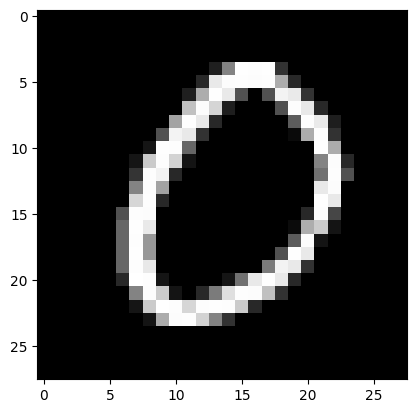

In [15]:
images, labels = next(iter(test_loader))
image = images[0].reshape(mnist_image_size)
label = labels[0]

print(image.shape)

pred = jnp.argmax(mlp_predict(mlp_params, np.ravel(image)))
print(f"Prediction: {pred}")
print(f"GT: {label}")

plt.imshow(image, cmap="gray")
plt.show()

(512, 784)
(28, 28)


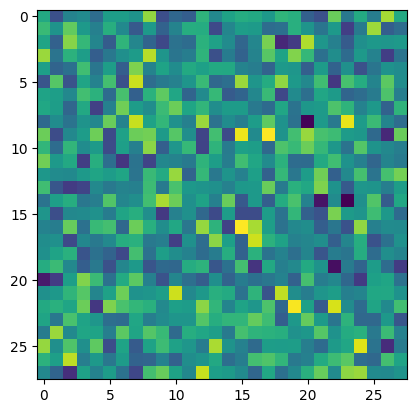

In [16]:
w = mlp_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_image_size)
print(w_single.shape)
plt.imshow(w_single)
plt.show()

(128, 256)


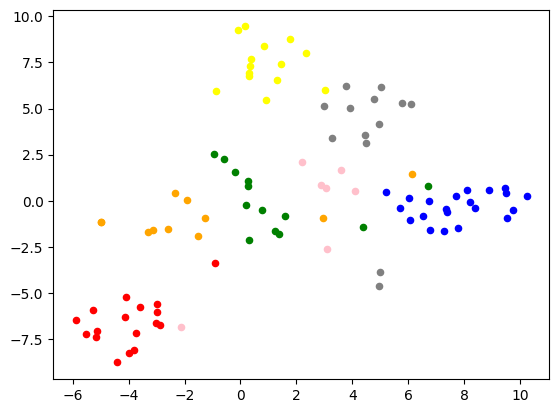

In [26]:
from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]
    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation


batched_fetch_activation = jax.vmap(fetch_activations, in_axes=(None, 0))
images, labels = next(iter(test_loader))

batch_activation = batched_fetch_activation(mlp_params, images)
print(batch_activation.shape)  # (128, 2)

tnse_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(batch_activation)
label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for cls in range(7):
    plt.scatter(tnse_embeddings[labels == cls, 0], tnse_embeddings[labels == cls, 1], s=20, color=label_to_color_map[cls])
plt.show()

🧠 What Are "Dead Neurons"?

Dead neurons are neurons that get "stuck" at zero activation (due to ReLU) and never fire for any input. This typically happens when:

The weights and biases cause the pre-activation (before ReLU) to always be negative
The neuron outputs ReLU(negative_value) = 0 for all inputs
This is a serious problem because dead neurons:

- Don't contribute to learning (zero gradients)
- Waste model capacity
- Can indicate poor initialization or learning rate issues

In [28]:
# Dead neurons

def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = jax.vmap(fetch_activations2, in_axes=(None, 0))
batch_activations = batched_fetch_activations2(mlp_params, images)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]


for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(
        dead_neurons[layer_id],
        (activations == 0).all(axis=0)
    )

In [30]:
# np.sum() applied to a boolean array counts the number of True elements.
# This prints the count of dead neurons for each hidden layer in the MLP based on the provided batch.
for layers in dead_neurons:
    print(np.sum(layers))

0
6


Detecting dead neurons is crucial for diagnosing issues during the training of deep neural networks:

1. **Poor Initialization**: If initialization is bad, many inputs to ReLU can be pushed into the negative region immediately.
2. **High Learning Rate**: Using a learning rate that is too high can cause large weight updates that push the weighted $sum(z)$ deep into the negative regime, permanently *"killing"* the neuron.
3. **Low Capacity**: If the network is struggling to learn, some neurons may be redundant and consistently turn off.